# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Imports

In [3]:
import datahandler

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Incidents

In [4]:
data_preprocessor = datahandler.DataPreprocessorOUS_V2()
data_preprocessor.execute()

data_loader = datahandler.DataLoader(datahandler.DataPreprocessorOUS_V2)
data_loader.execute(clean=True, processed=True, enhanced=True)

Loading dataset: 100%|██████████| 6/6 [00:15<00:00,  2.56s/it]


In [5]:
df = data_loader.enhanced_incidents_df

# Simulation Results

In [88]:
dfs = []
filenames = ['1_segment.csv', '6_segment.csv', '12_segment.csv', '24_segment.csv', 'metrics_2024-04-10_16-37-54.csv']

for filename in filenames:
    df = pd.read_csv('./metrics/' + filename)
    response_time_cols = ['duration_incident_creation', 'duration_resource_appointment',
                        'duration_resource_preparing_departure', 'duration_dispatching_to_scene']
    df['total_response_time'] = df[response_time_cols].sum(axis=1) / 60
    dfs.append(df)


# Response Time Histograms

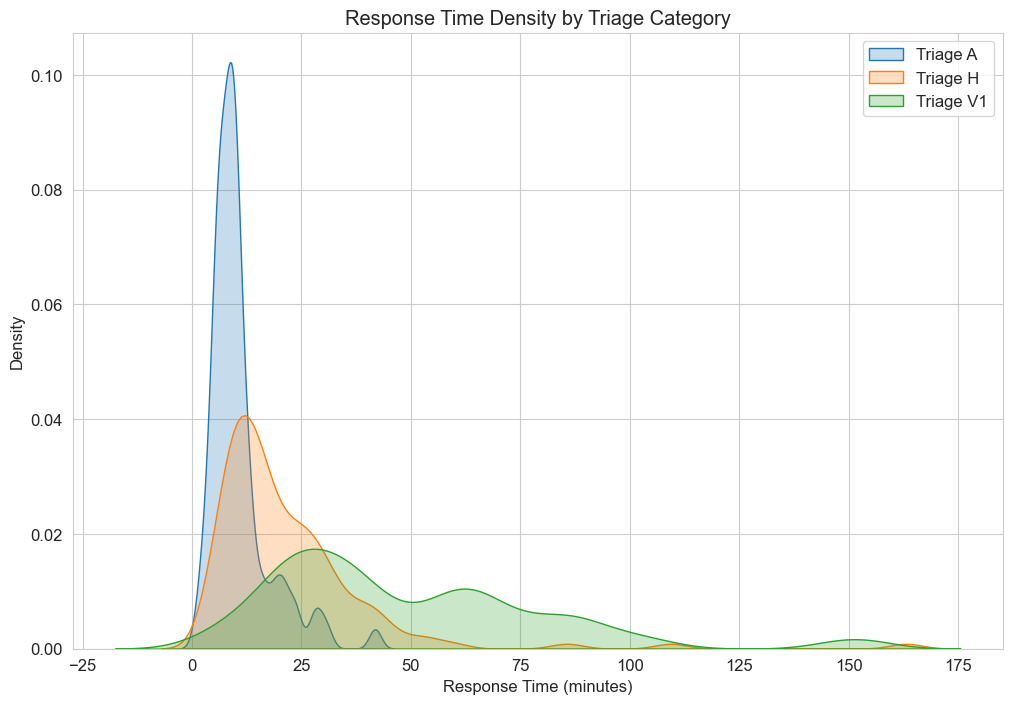

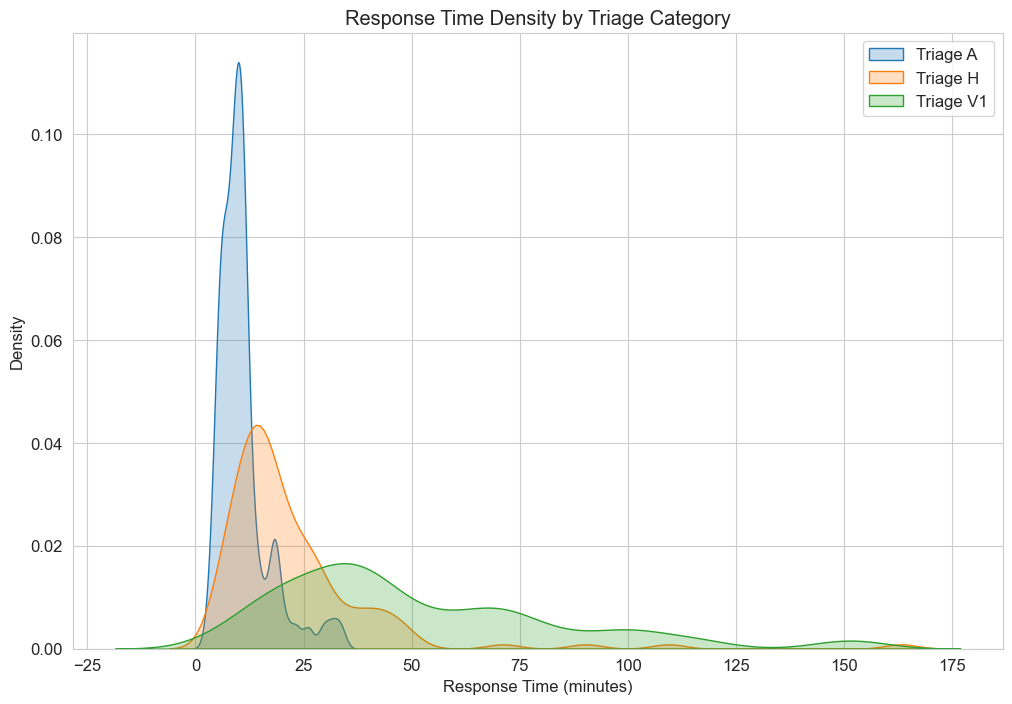

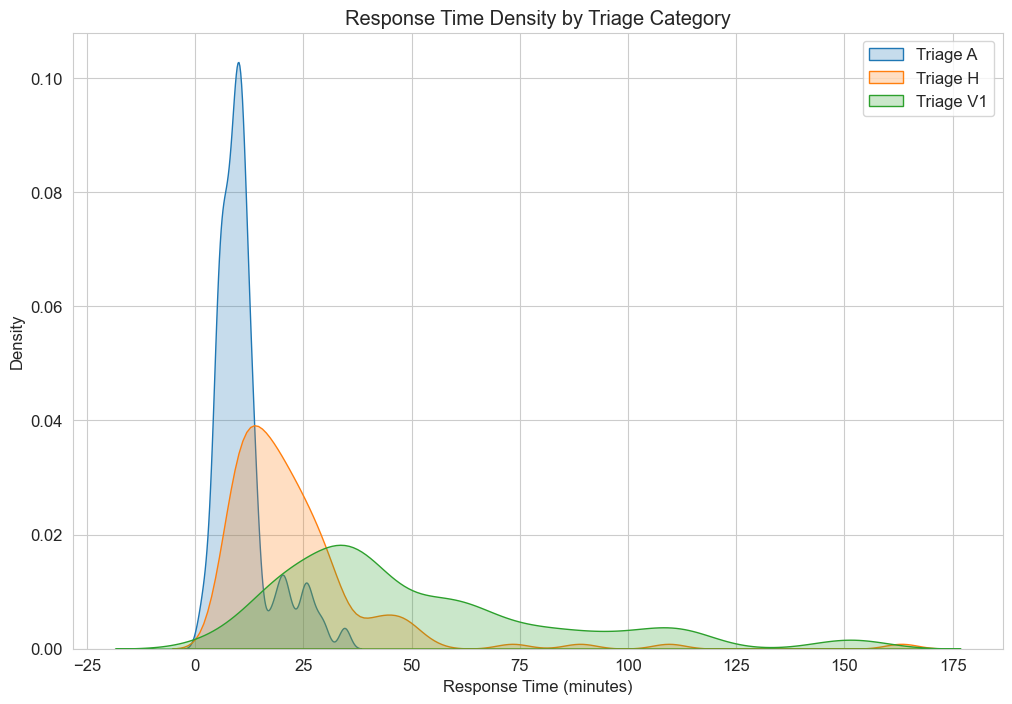

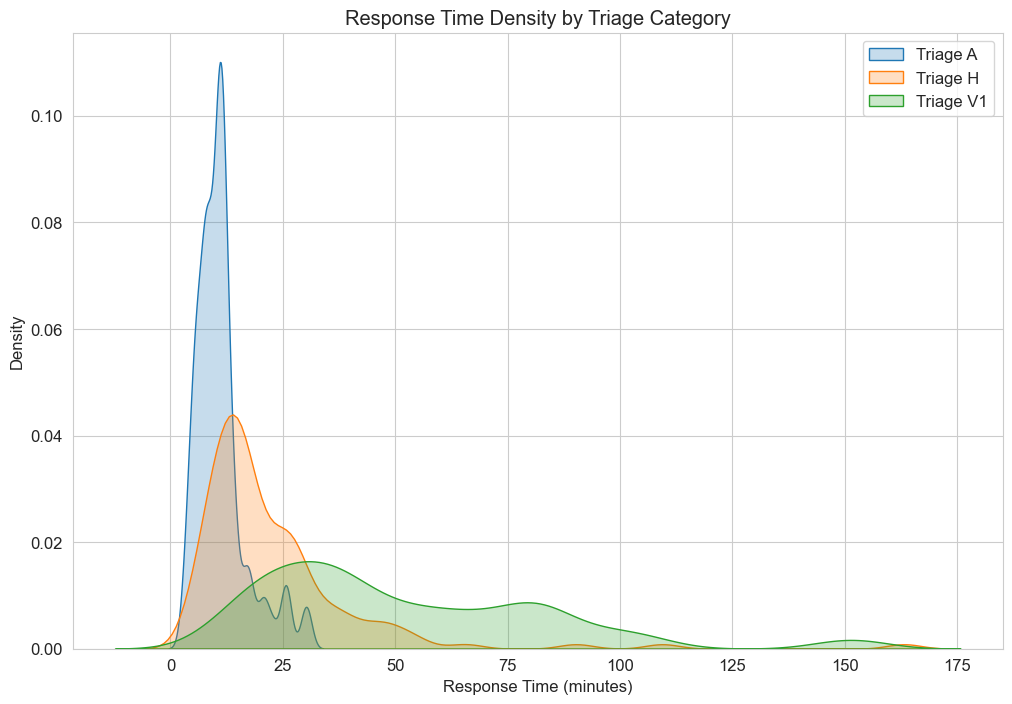

In [62]:
for df in dfs:
    response_time_cols = ['duration_incident_creation', 'duration_resource_appointment',
                        'duration_resource_preparing_departure', 'duration_dispatching_to_scene']
    df['total_response_time'] = df[response_time_cols].sum(axis=1) / 60

    plt.figure(figsize=(12, 8))

    for triage_category in df['triage_impression_during_call'].unique():
        subset = df[df['triage_impression_during_call'] == triage_category]
        sns.kdeplot(subset['total_response_time'], bw_adjust=0.5, label=f'Triage {triage_category}', fill=True)

    plt.title('Response Time Density by Triage Category')
    plt.xlabel('Response Time (minutes)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    """
    plt.figure(figsize=(12, 8))

    for urban in [True, False]:
        for triage_category in data['triage_impression_during_call'].unique():
            subset = data[(data['triage_impression_during_call'] == triage_category) & (data['urban'] == urban)]
            sns.kdeplot(subset['total_response_time'], bw_adjust=0.5, label=f'Triage {triage_category}, Urban {urban}', fill=True)
            
    plt.title('Response Time Density by Triage Category and Urbanness')
    plt.xlabel('Response Time (minutes)')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    """



# Mean and Median

In [91]:
from IPython.display import display

for df in dfs:
    stats = df.groupby(['triage_impression_during_call', 'urban'])['total_response_time'].agg(['mean', 'median']).reset_index()
    stats['mean'] = (stats['mean'] / 60).round(2)
    stats['median'] = (stats['median'] / 60).round(2)
    stats.rename(columns={'triage_impression_during_call': 'Triage', 'mean': 'Mean (min)', 'median': 'Median (min)', 'urban': 'Urban'}, inplace=True)
    stats['Urban'] = stats['Urban'].map({True: 'Yes', False: 'No'})
    display(stats)

,Triage,Urban,Mean (min),Median (min)
0,A,No,0.26,0.24
1,A,Yes,0.17,0.15
2,H,No,0.39,0.42
3,H,Yes,0.37,0.27
4,V1,No,2.52,2.52
5,V1,Yes,0.76,0.62


,Triage,Urban,Mean (min),Median (min)
0,A,No,0.23,0.18
1,A,Yes,0.18,0.16
2,H,No,0.37,0.33
3,H,Yes,0.38,0.28
4,V1,No,2.52,2.52
5,V1,Yes,0.79,0.65


,Triage,Urban,Mean (min),Median (min)
0,A,No,0.22,0.19
1,A,Yes,0.18,0.16
2,H,No,0.31,0.28
3,H,Yes,0.39,0.32
4,V1,No,2.52,2.52
5,V1,Yes,0.79,0.62


,Triage,Urban,Mean (min),Median (min)
0,A,No,0.26,0.19
1,A,Yes,0.18,0.17
2,H,No,0.29,0.28
3,H,Yes,0.39,0.28
4,V1,No,2.52,2.52
5,V1,Yes,0.81,0.65


,Triage,Urban,Mean (min),Median (min)
0,A,No,0.20,0.17
1,A,Yes,0.18,0.15
2,H,No,0.35,0.28
3,H,Yes,0.37,0.26
4,V1,No,2.52,2.52
5,V1,Yes,0.77,0.61


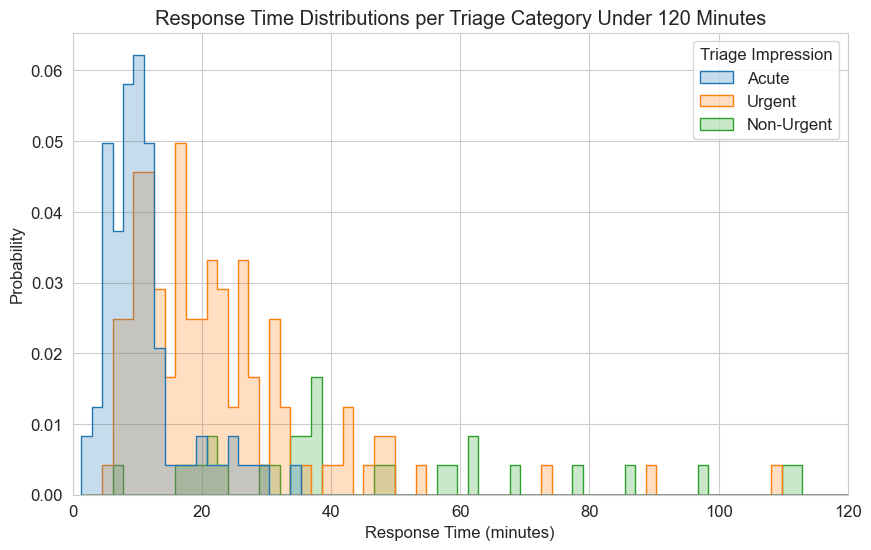

In [43]:
data['total_response_time_minutes'] = data['total_response_time']

category_mapping = {
    'A': 'Acute',
    'H': 'Urgent',
    'V1': 'Non-Urgent'
}

data['Triage Impression'] = data['triage_impression_during_call'].map(category_mapping)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

hist_plot = sns.histplot(
    data=data,
    x='total_response_time_minutes',  # Updated to use minutes
    hue='Triage Impression',
    element="step",
    stat="probability",
    common_norm=True,
    palette="tab10",
    bins=100
)
plt.title('Response Time Distributions per Triage Category Under 120 Minutes')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Probability')
plt.xlim(left=0, right=120)

plt.show()


# Response Time Compliance

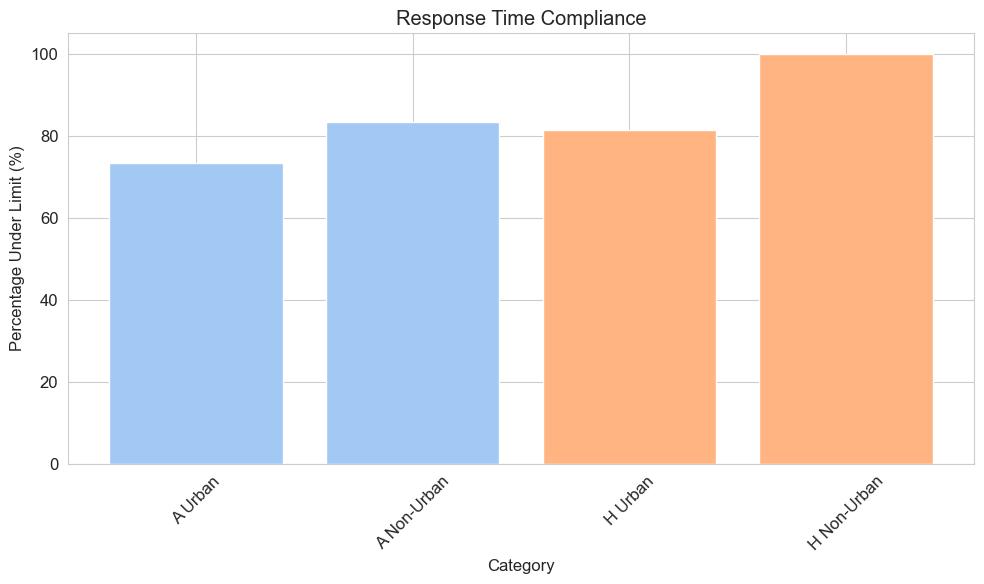

In [86]:
# Define limits
limits = {
    'A': {'Urban': 12, 'Non-Urban': 25},
    'H': {'Urban': 30, 'Non-Urban': 40}
}

# Create a function to determine if the response is under the limit
def is_under_limit(row):
    for triage in ['A', 'H']:
        if row['triage_impression_during_call'] == triage:
            limit_type = 'Urban' if row['urban'] else 'Non-Urban'
            return row['total_response_time'] <= limits[triage][limit_type]
    return False


# Apply the function
df['is_under_limit'] = df.apply(is_under_limit, axis=1)

# Filter out the triage categories other than A and H
filtered_data = df[df['triage_impression_during_call'].isin(['A', 'H'])]

# Calculate percentages
percentage_under_limit = filtered_data.groupby(['triage_impression_during_call', 'urban'])['is_under_limit'].mean() * 100

# Prepare data for bar chart
bar_data = percentage_under_limit.reset_index()
bar_data['Area Type'] = bar_data['urban'].map({True: 'Urban', False: 'Non-Urban'})
bar_data['Category'] = bar_data['triage_impression_during_call'] + " " + bar_data['Area Type']

sort_order = ['A Urban', 'A Non-Urban', 'H Urban', 'H Non-Urban']
bar_data['sort_key'] = pd.Categorical(bar_data['Category'], categories=sort_order, ordered=True)
bar_data = bar_data.sort_values('sort_key')

palette = sns.color_palette()
blue = palette[0]  # Default blue
orange = palette[1]  # Default orange

# Assign colors based on the triage category
bar_data['color'] = bar_data['triage_impression_during_call'].map({'A': blue, 'H': orange})

# Plotting the bar chart with Seaborn's blue and orange colors
plt.figure(figsize=(10, 6))
for i, row in bar_data.iterrows():
    plt.bar(row['Category'], row['is_under_limit'], color=row['color'])
# Assign colors based on the triage category
bar_data['color'] = bar_data['triage_impression_during_call'].map({'A': 'blue', 'H': 'orange'})

# Adding labels and title
plt.xlabel('Category')
plt.ylabel('Percentage Under Limit (%)')
plt.title('Response Time Compliance')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


# Histogram Comparison

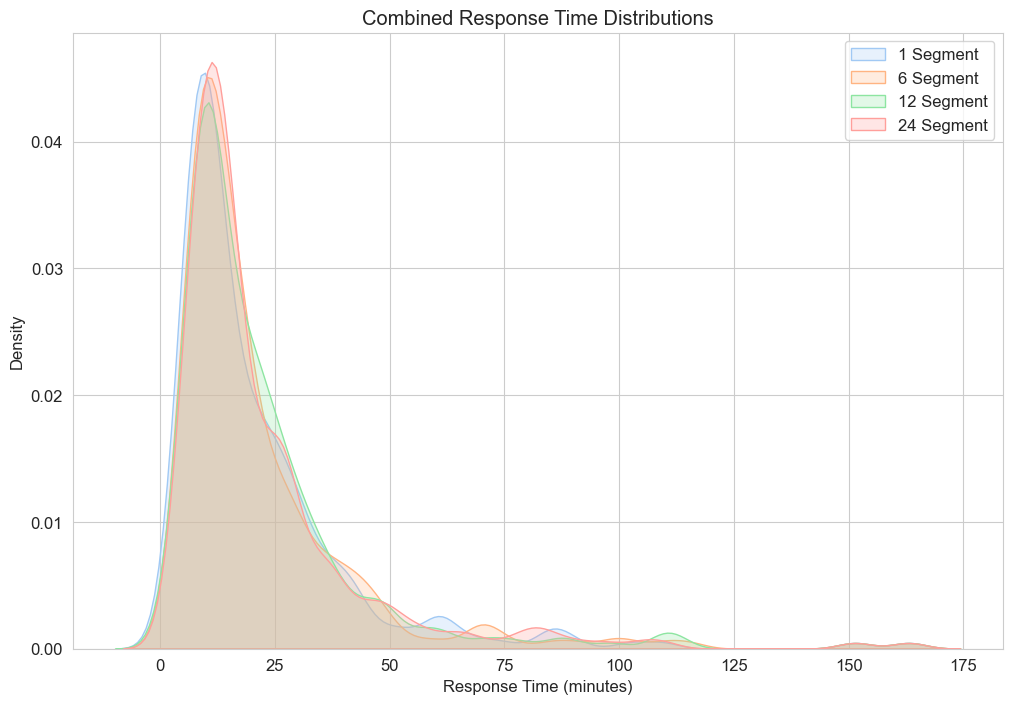

In [69]:
sns.set_palette("pastel")

plt.figure(figsize=(12, 8))

titles = ['1 Segment', '6 Segment', '12 Segment', '24 Segment']

for df, title in zip(dfs, titles):
    sns.kdeplot(df['total_response_time'], bw_adjust=0.5, label=title, fill=True)

plt.title('Combined Response Time Distributions')
plt.xlabel('Response Time (minutes)')
plt.ylabel('Density')
plt.legend()

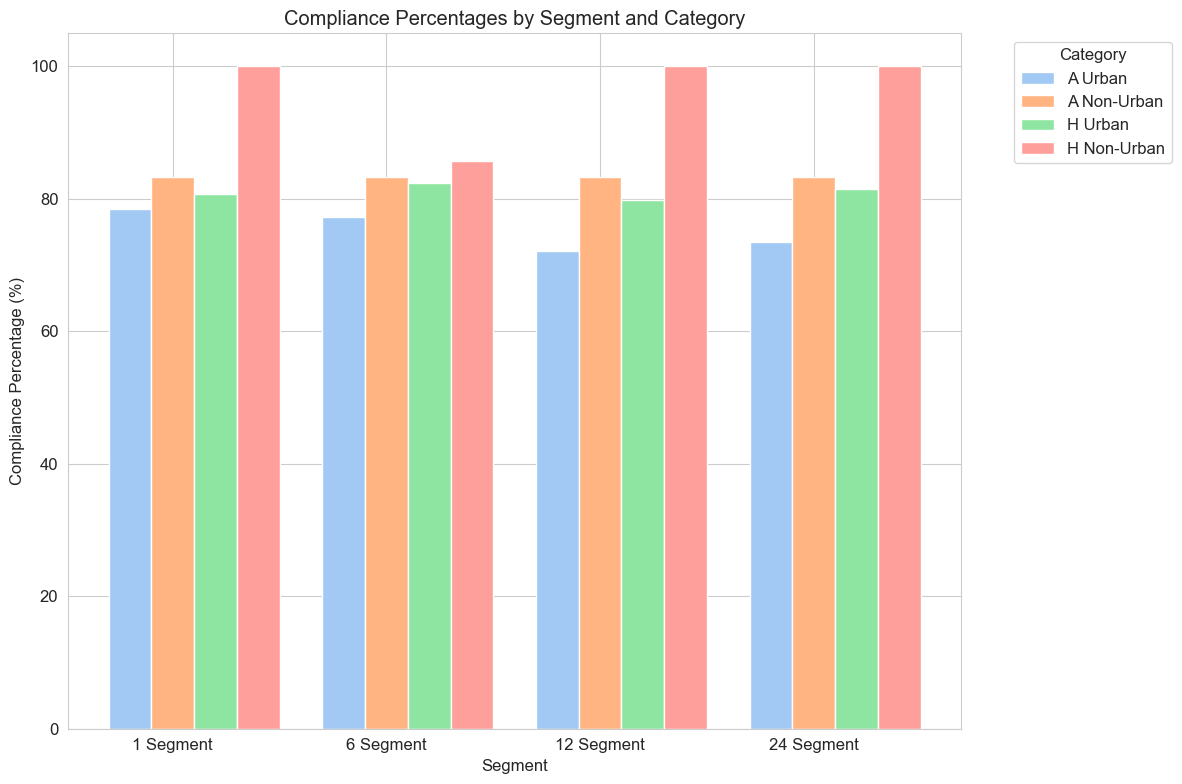

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

limits = {
    'A': {'Urban': 12, 'Non-Urban': 25},
    'H': {'Urban': 30, 'Non-Urban': 40}
}

segments = ['1 Segment', '6 Segment', '12 Segment', '24 Segment']

compliance_percentages = []

for df in dfs:
    percentages = {}
    for triage, areas in limits.items():
        for area, time_limit in areas.items():
            is_urban = True if area == 'Urban' else False
            compliant = df[(df['triage_impression_during_call'] == triage) & (df['urban'] == is_urban) & (df['total_response_time'] <= time_limit)]
            total = df[(df['triage_impression_during_call'] == triage) & (df['urban'] == is_urban)]
            compliance_rate = (len(compliant) / len(total) * 100) if len(total) > 0 else 0
            percentages[f'{triage} {area}'] = compliance_rate
    compliance_percentages.append(percentages)

plt.figure(figsize=(12, 8))
sns.set_palette("pastel")

bar_width = 0.2
index = pd.Index(segments, name='Segments')
df_plot = pd.DataFrame(compliance_percentages, index=index).T

positions = list(range(len(segments)))
for i, category in enumerate(df_plot.index):
    plt.bar([p + bar_width*i for p in positions], 
            df_plot.loc[category], 
            bar_width, 
            label=category)

plt.xlabel('Segment')
plt.ylabel('Compliance Percentage (%)')
plt.title('Compliance Percentages by Segment and Category')
plt.xticks([p + bar_width for p in positions], segments)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


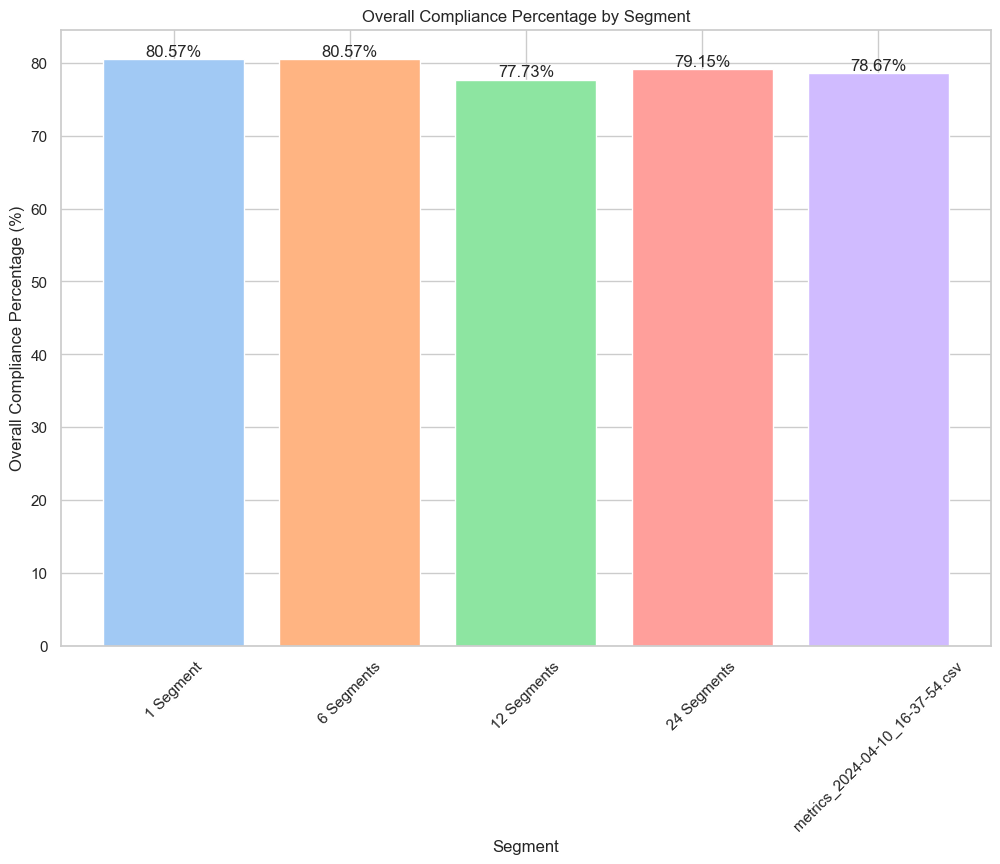

In [96]:
limits = {
    'A': {'Urban': 12, 'Non-Urban': 25},
    'H': {'Urban': 30, 'Non-Urban': 40}
}

segments = ['1 Segment', '6 Segments', '12 Segments', '24 Segments', 'metrics_2024-04-10_16-37-54.csv']

overall_compliance_percentages = []

for df in dfs:
    total_compliant = 0
    total_cases = 0
    for triage, areas in limits.items():
        for area, time_limit in areas.items():
            is_urban = True if area == 'Urban' else False
            compliant_cases = df[(df['triage_impression_during_call'] == triage) & (df['urban'] == is_urban) & (df['total_response_time'] < time_limit)]
            total_compliant += len(compliant_cases)
            total_cases += len(df[(df['triage_impression_during_call'] == triage) & (df['urban'] == is_urban)])

    overall_rate = (total_compliant / total_cases * 100) if total_cases > 0 else 0
    overall_compliance_percentages.append(overall_rate)


plt.figure(figsize=(12, 8))
sns.set_palette("pastel")
bars = plt.bar(segments, overall_compliance_percentages, color=sns.color_palette("pastel", n_colors=len(segments)))

plt.xlabel('Segment')
plt.ylabel('Overall Compliance Percentage (%)')
plt.title('Overall Compliance Percentage by Segment')
plt.xticks(rotation=45)

# Adding the percentage on top of each bar
for bar, percentage in zip(bars, overall_compliance_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()


ValueError: x and y must have same first dimension, but have shapes (4,) and (5,)

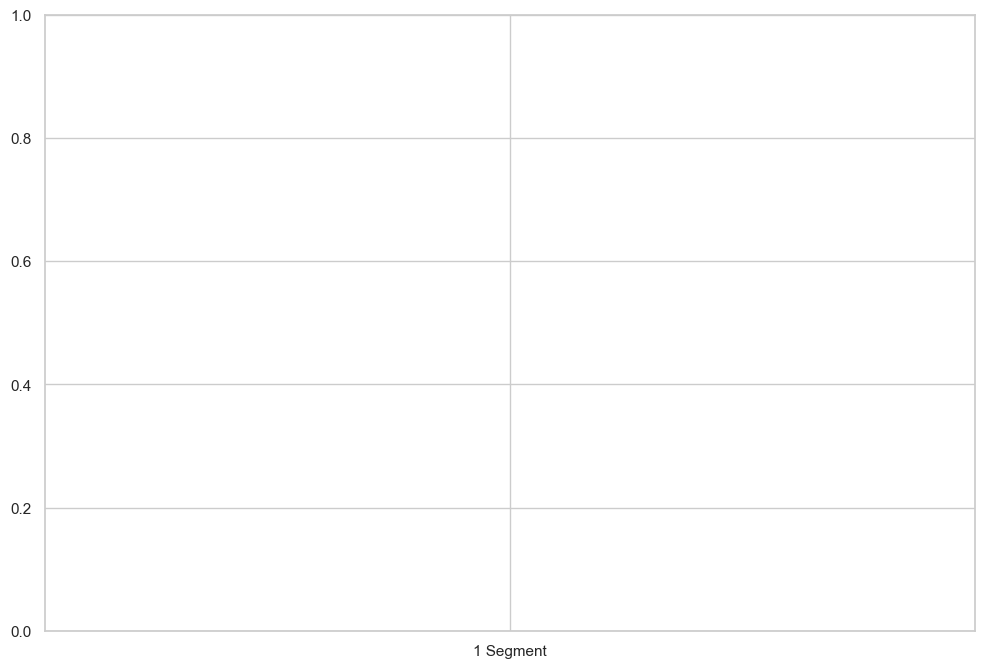

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample setup; replace 'dfs' and 'segments' with your actual data
# dfs = [df1, df2, df3, df4] where each df represents a segment and contains 'triage_impression_during_call' and 'total_response_time'
segments = ['1 Segment', '6 Segments', '12 Segments', '24 Segments']

# Placeholder for mean response times
mean_response_times = {'A': [], 'H': [], 'V1': []}

# Calculate mean response times for each category in each DataFrame
for df in dfs:
    for category in ['A', 'H', 'V1']:
        # Filter the DataFrame for the current category
        category_df = df[df['triage_impression_during_call'] == category]
        # Calculate the mean response time and append to the appropriate list
        mean_time = category_df['total_response_time'].mean()
        mean_response_times[category].append(mean_time)

# Plotting
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Colors for each category
colors = {'A': 'blue', 'H': 'orange', 'V1': 'green'}

# Plot each category's mean response times across segments
for category, times in mean_response_times.items():
    plt.plot(segments, times, marker='o', color=colors[category], label=category)

plt.title('Mean Response Times by Triage Category Across Segments')
plt.xlabel('Segment')
plt.ylabel('Mean Response Time (minutes)')
plt.xticks(rotation=45)
plt.legend(title='Triage Category')

plt.show()


In [99]:
import pandas as pd

# Assuming df is your DataFrame and it contains 'triage_impression_during_call', 'urban', and 'total_response_time' columns
# Replace df with the actual name of your DataFrame variable

def count_violations(row):
    """Count the violations based on triage level and urban setting."""
    limits = {
        'A': {'Urban': 12, 'Non-Urban': 25},  # Limits in seconds
        'H': {'Urban': 30, 'Non-Urban': 40}
    }
    
    triage = row['triage_impression_during_call']
    urban_setting = 'Urban' if row['urban'] else 'Non-Urban'
    response_time = row['total_response_time']  # Assuming 'total_response_time' is in seconds
    
    # Determine the limit based on triage and urban setting
    limit = limits.get(triage, {}).get(urban_setting, float('inf'))
    
    # Check if the response time exceeds the limit
    if response_time > limit:
        return 1  # Violation
    return 0  # No violation

# Apply the function to each row and sum up the violations
df = dfs[4]
df['violation'] = df.apply(count_violations, axis=1)
total_violations = df['violation'].sum()

# Calculate the percentage of violations
total_cases = len(df)
violation_percentage = (total_violations / total_cases * 100) if total_cases > 0 else 0

print(f"Total Violations: {total_violations}")
print(f"Violation Percentage: {violation_percentage:.2f}%")


Total Violations: 45
Violation Percentage: 18.67%
